# Giant number fluctuations in active turbulence

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq, readseq, match_hist
from scipy.signal import savgol_filter
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from scipy.interpolate import griddata
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH
import matplotlib
import pandas as pd
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = 10, 6
matplotlib.rcParams['font.family'] = 'serif'

* Preliminary result - one set of videos

In [ ]:
folders = [r'D:\Wei\Dynamics_raw\df_result\20',
           r'D:\Wei\Dynamics_raw\df_result\40',
           r'D:\Wei\Dynamics_raw\df_result\60',
           r'D:\Wei\Dynamics_raw\df_result\80',
           r'D:\Wei\Dynamics_raw\df_result\100']
data = pd.DataFrame()
for f in folders:
    a = average_NF(f, avrange=[400, 1000])
    name = int(os.path.split(f)[1])
    a = a.assign(Name=name)
    data = data.append(a)
data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig2-GNF\GNF_data.csv', index=False)

Text(0, 0.5, '$\\Delta N/\\sqrt{N}$')

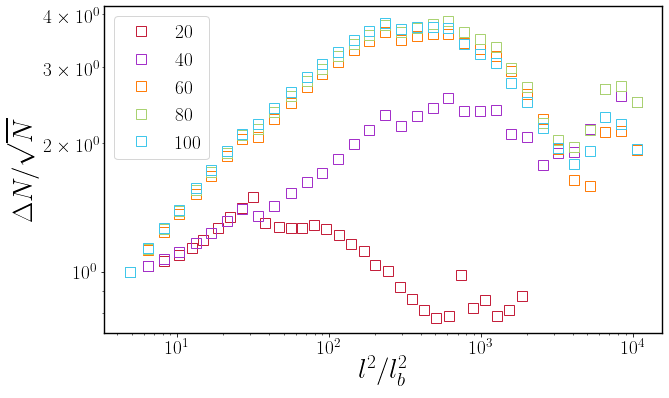

In [16]:
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig2-GNF\GNF_data.csv')
lb = 3 # um
mpp = 0.33 
count = 0
slopeL = []
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]    
    # to plot, xx yy
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[xx<2e1]
    y = yy.loc[xx<2e1] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
#     plt.plot(xf, yf, ls='--', color='black')
#     plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1
    slopeL.append(slope)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

Text(0, 0.5, 'slope')

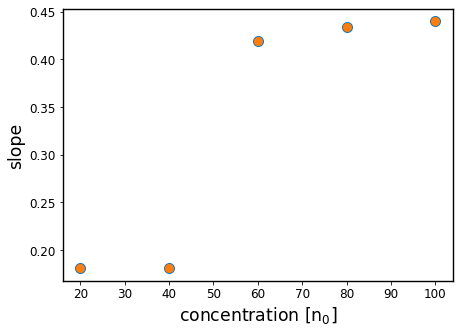

In [8]:
n = [20, 40, 60, 80, 100]
plt.figure(figsize=(7, 5))
plt.plot(n, slopeL, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('slope')

* Improved data - multiple repeats

## Alternative method for DF

Text(10, 2.558336368008464, '0.5')

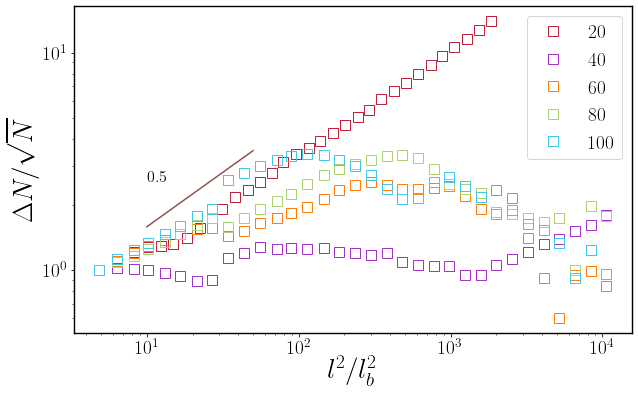

In [27]:
lb = 3 # um
mpp = 0.33 # um per pixel
folder = r'D:\Wei\Dynamics_raw\df2_result'
names = ['20', '40', '60', '80', '100']
count = 0
for name in names:
    subdata = pd.read_csv(os.path.join(folder, name, 'df_average.csv'))
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    count += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([10, 50])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(x[0], y.mean(), '0.5')

__Comment__: the kinks for all the curves happen at $l^2/l_b^2\approx25$, which corresponds to $l\approx45$ pixels. This value does not agree with the bpass parameter (100 px), and thus it should not be a result from image preprocessing. However, all kinks happens at the same $l$ is indeed suspicious. 

# What if no bpass?

Text(10, 2.558336368008464, '0.5')

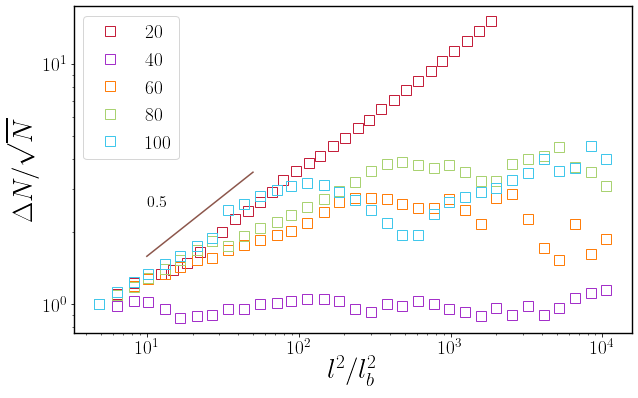

In [26]:
lb = 3 # um
mpp = 0.33 # um per pixel
folder = r'D:\Wei\Dynamics_raw\df2nobp_result'
names = ['20', '40', '60', '80', '100']
count = 0
for name in names:
    subdata = pd.read_csv(os.path.join(folder, name, 'df_average.csv'))
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy.iat[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    count += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([10, 50])
y = x**0.5 / 2
plt.plot(x, y)
plt.text(x[0], y.mean(), '0.5')

<b style='color:green'>Comment:</b> no bpass make the kinks in 40, 60 and 80 curves much less pronounced. 100 curve does not get better much. This indicates that most kinks are indeed induced by bpass, but for some curves, the cause of the kink is still a puzzle. 

<b style='color:red'>Comment:</b> The large slope of 20 curve is anomalous, but not surprising. At 20 n$_0$, the bacterial suspension barely display the cluster-like black spots. Individual bacterium can be seen and the image intensity variation within single bacterium body dominates the intensity variation in the image - rather than the concentration. Therefore, I don't apply GNF based on image intensity for low concentration suspensions in the future. 

__Thought__: Spatial and temporal variations are equivalent in a homogeneous dynamical system. Necessary conditions are: long enough time for temporal variation evaluation, and large enough box for spatial variation evaluation. 

_Science_ __320__, 612.